## BDP Part 4


In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
pip install nltk -U

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import time
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [7]:
bucket_name = 'msca-bdp-students-bucket'
prefix = 'shared_data/sravani/processed'
df = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')
bucket_name = 'msca-bdp-students-bucket'
prefix = 'shared_data/sravani/orgs'
df_orgs = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

23/03/10 06:51:11 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
df_joined = df_orgs.select('user_id_str', 'Organisation').dropDuplicates(['user_id_str'])
df_joined = df.join(df_joined, 'user_id_str', 'left')
df_joined = df_joined.na.fill(value='Other', subset=['Organisation'])

In [ ]:
from pyspark.sql.functions import col
sample = df_joined.sample(withReplacement=True, fraction=0.001, seed=123)
sample1 = sample.orderBy('tweet_created_at',ascending=False).select('user_id_str','Organisation',col('tweet_text').alias('text')).filter(sample['tweet_retweeted_status'].isNull())
sample2 = sample1.select('text').rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = sample2\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [22]:
row = Row('text')
df_text = sample2.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{@yeosinin Colleg...,4380
{@BendittJeffrey ...,4381
{Wreck on College...,4382
{ASUU University ...,4383
{@drakedawgs @Nic...,4384


In [23]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[heard, osu, fan, osu, fan, act, like, harrison, actually, done]",0
1,"[changes, sounds, realize, changed, places]",1
2,"[worth, pointing, received]",2
3,"[picture, compare, board]",3
4,"[pablo, received, offer, admission, law, school, spring, immediately]",4


In [24]:
# bucket_name = 'msca-bdp-students-bucket'
# prefix = 'shared_data/sravani/tokens'

# # Write the DataFrame to Parquet format
# df_text.write.format('parquet').save('gs://' + bucket_name + '/' + prefix + '/text.parquet')
# df_tokens.write.format('parquet').save('gs://' + bucket_name + '/' + prefix + '/tokens.parquet')

In [25]:
# sample1.write.format('parquet').save('gs://' + bucket_name + '/' + prefix + '/sample1.parquet')

In [26]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [27]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[heard, osu, fan, osu, fan, act, like, harrison, actually, done]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[changes, sounds, realize, changed, places]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[worth, pointing, received]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[picture, compare, board]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[pablo, received, offer, admission, law, school, spring, immediately]",4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [28]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()
df_vectorize = df_vectorize.where(num_nonzeros("features") >= 1)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [30]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
4126,{“Big jump putt b...,"[jump, putt, bird...","(16631,[9,41,189,...","[[1.56939628E8], ..."
4371,{@tisjoe @BruceIr...,"[brady, threw, li...","(16631,[5,61,162,...","[[3.4717271E8], [..."
4191,{It was amazing t...,"[amazing, work, y...","(16631,[35,50,79,...","[[1.04460723E8], ..."
4174,{@UCF_MBB @tayxhe...,"[first, college, ...","(16631,[0,17,56,3...","[[4.7945584E7], [..."
4256,{@luffydmonkey941...,"[people, got, edu...","(16631,[22,23,46,...","[[4.1891233E7], [..."


In [55]:
jaccard_distance = 0.2

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))

df_dups_text.cache()
dups_2 = df_dups_text.select('id_A').distinct().count()


In [48]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))

In [49]:
#df_dups_text.cache()
dups_3 = df_dups_text.select('id_A').distinct().count()

In [56]:
jaccard_distance = 0.4

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))

df_dups_text.cache()
dups_4 = df_dups_text.select('id_A').distinct().count()

In [50]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))


In [51]:
df_dups_text.cache()
dups_5 = df_dups_text.select('id_A').distinct().count()

In [57]:
jaccard_distance = 0.6

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))

df_dups_text.cache()
dups_6 = df_dups_text.select('id_A').distinct().count()

In [52]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))


In [53]:
df_dups_text.cache()
dups_7 = df_dups_text.select('id_A').distinct().count()

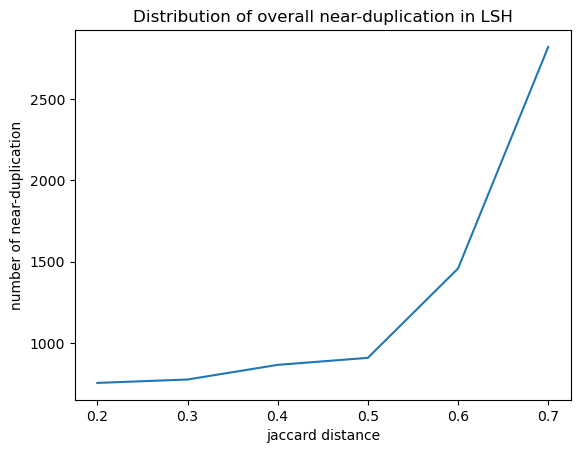

In [58]:
#plot distributions of near duplicate under 3 threshold
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
plt.plot(thresholds, [dups_2, dups_3, dups_4, dups_5, dups_6, dups_7])
plt.title('Distribution of overall near-duplication in LSH')
plt.xlabel('jaccard distance')
plt.ylabel('number of near-duplication')
plt.xticks(thresholds)
plt.show()

In [61]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))

df_dups_text.cache()
dups_5 = df_dups_text.select('id_A').distinct().count()

In [62]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.orderBy('id_A').limit(5).toPandas()

23/03/10 07:45:25 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


,distCol,id_A,id_B,text_A,text_B
0,0.000000,8,490,"(@manjr58503101 ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.… https://t.co/2xKbmiFdUm,)","(@coding_notes ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.… https://t.co/aG3HcHnCi6,)"
1,0.000000,8,458,"(@manjr58503101 ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.… https://t.co/2xKbmiFdUm,)","(@MrHarbbay ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.\n\nSo… https://t.co/izuPbOF0kn,)"
2,0.000000,8,372,"(@manjr58503101 ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.… https://t.co/2xKbmiFdUm,)","(@69_F_420 ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.\n\nSom… https://t.co/S0Zvyc7Eau,)"
3,0.000000,8,489,"(@manjr58503101 ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school.… https://t.co/2xKbmiFdUm,)","(@BarakaelMaseri ✨ Beautified ✨\nDuring the pandemic, more than a million children in India had to drop out of school… https://t.co/ek1st8sTlV,)"
4,0.222222,9,79,"(The teacher assigned me to meet the new students at the school gate 4xQ1194 \n#温州 #宜昌 https://t.co/NQ2TY67yzD,)","(The teacher assigned me to meet the new students at the school gate 2cX2190 \n#安康 #汉中 #商洛 https://t.co/tcWcWJRi83,)"


In [63]:
records = df_hashed_text.count()
df_dups_text = df_dups_text.dropna()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  13814
Duplicate titles based on { 0.5 } jaccard distance:  909
Unique titles based on { 0.5 } jaccard distance:  0.5 :  12905


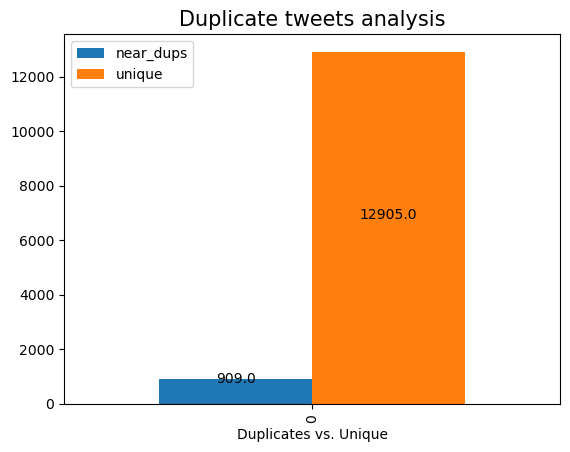

In [64]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicate tweets analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [65]:
df_dups_1 = df_dups_text.select(col('id_A').alias('id')).distinct().withColumn('is_dups',lit('near_dups'))

df_final = sample1.select('Organisation').rdd.zipWithIndex().toDF(['org','id'])\
.join(df_dups_1,'id','left')\
.na.fill(value='unique',subset=['is_dups'])\
.select('id',col('org.Organisation').alias('org'),'is_dups')

df_final.show(10)

+---+-----+---------+
| id|  org|  is_dups|
+---+-----+---------+
|  0|Other|   unique|
|  1|Other|   unique|
|  2|Other|   unique|
|  3|Other|   unique|
|  4|Other|   unique|
|  5|Other|   unique|
|  6|Other|   unique|
|  7|Other|   unique|
|  8|Other|near_dups|
|  9|Other|near_dups|
+---+-----+---------+
only showing top 10 rows



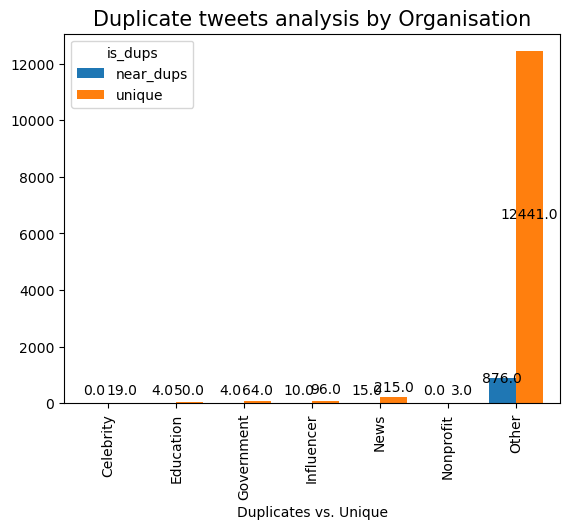

In [66]:
df_plt = df_final.groupBy('org','is_dups').agg(count('*').alias('cnt')).toPandas()

ax=df_plt.pivot(index='org', columns='is_dups', values='cnt').plot(kind='bar', fontsize=10, color=['C0', 'C1'],
                                                                align='center', width=0.8, 
                                                                xlabel="Duplicates vs. Unique")

ax.set_title('Duplicate tweets analysis by Organisation', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [20]:
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
